I
(1801, 3601)


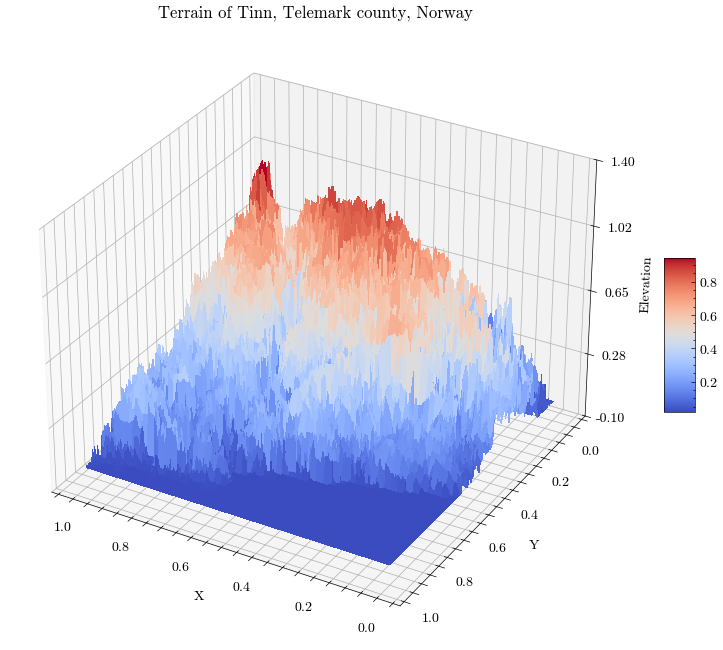

In [44]:
import numpy as np
import os
from imageio import imread
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from PIL import Image
from matplotlib.ticker import LinearLocator, FormatStrFormatter
try:
    import scienceplots
    plt.style.use(['science', 'no-latex'])
except ImportError:
    plt.style.use('ggplot')
# Load the terrain
file_name = 'SRTM_data_Norway_2.tif'
image = Image.open(file_name, mode='r')
print(image.mode)
print(image.size)
image = image.convert('I')
# image.show()
x = np.linspace(0, 1, image.size[0])
y = np.linspace(0, 1, image.size[1])
X,Y = np.meshgrid(x,y)
Z = np.array(image)
Z = Z - np.min(Z)
Z = Z / np.max(Z)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
surf = ax.plot_surface(X,Y,Z,cmap=cm.coolwarm,linewidth=0, antialiased=False)
ax.set_zlim(-0.10, 1.40)
ax.zaxis.set_major_locator(LinearLocator(5))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Elevation")
plt.title("Terrain of Tinn, Telemark county, Norway")
ax.view_init(30, 30+90)
fig.colorbar(surf, shrink=0.2, aspect=5)
plt.savefig('figures/terrain.pdf', transparent=True, bbox_inches='tight')
plt.show()


In [45]:
# Basic OLS for terrain data

import miscellaneous as misc
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib import cm  # Import cm module
try:
    import scienceplots
    plt.style.use(['science', 'no-latex'])
except ImportError:
    plt.style.use('ggplot')

# Prepare the data for train-test split
X_design = np.vstack((X.ravel(), Y.ravel())).T
z_data = Z.ravel()  # Reshape z to match the shape of X

# Train-Test Split
X_train, X_test, z_train, z_test = misc.train_test_splitter(X_design, z_data, test_size=0.2)

# Lists to store errors and R^2 values
degree = 5
poly = misc.design_matrix(degree=degree)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

z_test_pred, z_train_pred, beta = misc.ols(X_train_poly, z_train, X_test_poly)

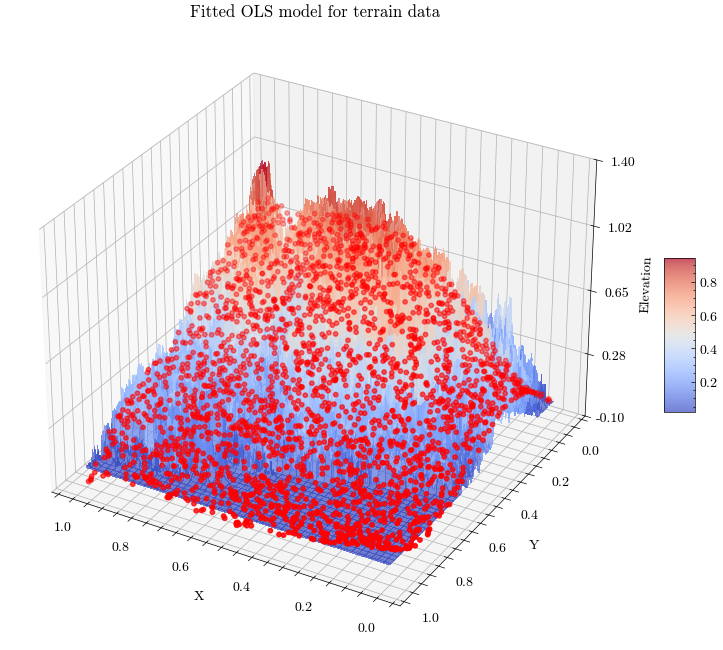

In [46]:
# plot the results
# plot every 100th point to save 
every_nth = 500
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False, alpha=0.7)
ax.set_zlim(-0.10, 1.40)
ax.zaxis.set_major_locator(LinearLocator(5))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.scatter(X_test[::every_nth, 0], X_test[::every_nth, 1], z_test_pred[::every_nth], color='r', s=10)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Elevation")
ax.view_init(30, 30+90)
fig.colorbar(surf, shrink=0.2, aspect=5)
plt.title("Fitted OLS model for terrain data")
plt.savefig('figures/terrain_ols_fit.pdf', transparent=True, bbox_inches='tight')
plt.show()

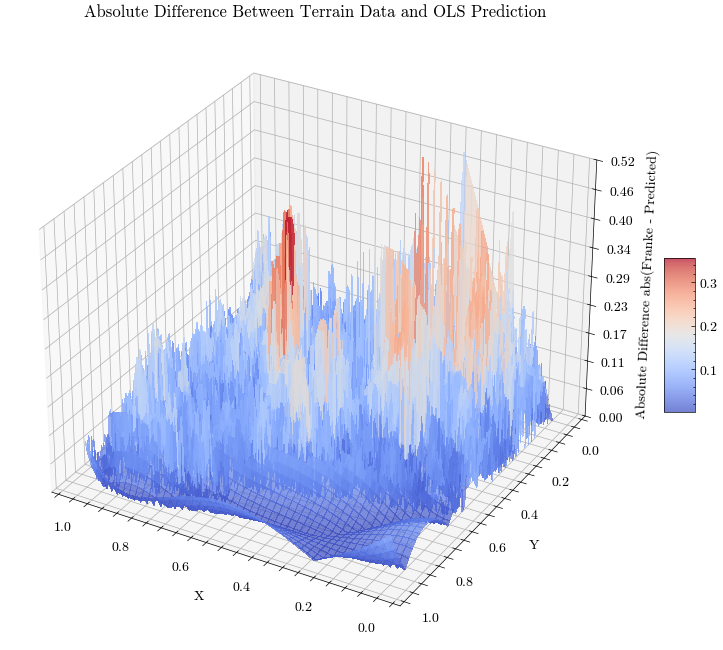

In [47]:
# For plotting the difference, we need predictions on the full grid
X_full_poly = poly.transform(X_design)  # Transform the full grid into polynomial features
z_full_pred = X_full_poly @ beta  # Predict on the full grid

# Reshape predictions to match the grid shape for plotting
z_full_pred_plot = z_full_pred.reshape(X.shape)

# Compute the absolute difference between Franke function and predicted values
z_diff = np.abs(z_data.reshape(Z.shape) - z_full_pred_plot)  # Reshape z_data to match Z.shape

# Plot the absolute difference
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
surf = ax.plot_surface(X, Y, z_diff, cmap=cm.coolwarm, linewidth=0, antialiased=False, alpha=0.7)
ax.set_zlim(0, np.max(z_diff))
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
fig.colorbar(surf, shrink=0.2, aspect=5)
ax.view_init(30, 30+90)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Absolute Difference abs(Franke - Predicted)')
ax.set_title('Absolute Difference Between Terrain Data and OLS Prediction')
plt.savefig('figures/terrain_diff_ols.pdf', transparent=True, bbox_inches='tight')
plt.show()

In [48]:
# Lists to store errors and R^2 values
mse_train_list, mse_test_list = [], []
r2_train_list, r2_test_list = [], []
beta_coefficients = []

# Polynomial Regression for degrees 1 to 5

degrees = np.arange(1, 6, 1)

for degree in degrees:
    poly = misc.design_matrix(degree=degree)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)
    
    z_test_pred, z_train_pred, beta = misc.ols(X_train_poly, z_train, X_test_poly)
    
    # Calculate MSE and R^2
    mse_train = misc.mean_squared_error(z_train, z_train_pred)
    mse_test = misc.mean_squared_error(z_test, z_test_pred)
    r2_train = misc.r2_score(z_train, z_train_pred)
    r2_test = misc.r2_score(z_test, z_test_pred)
    
    # Append results to the lists
    mse_train_list.append(mse_train)
    mse_test_list.append(mse_test)
    r2_train_list.append(r2_train)
    r2_test_list.append(r2_test)
    beta_coefficients.append(beta)

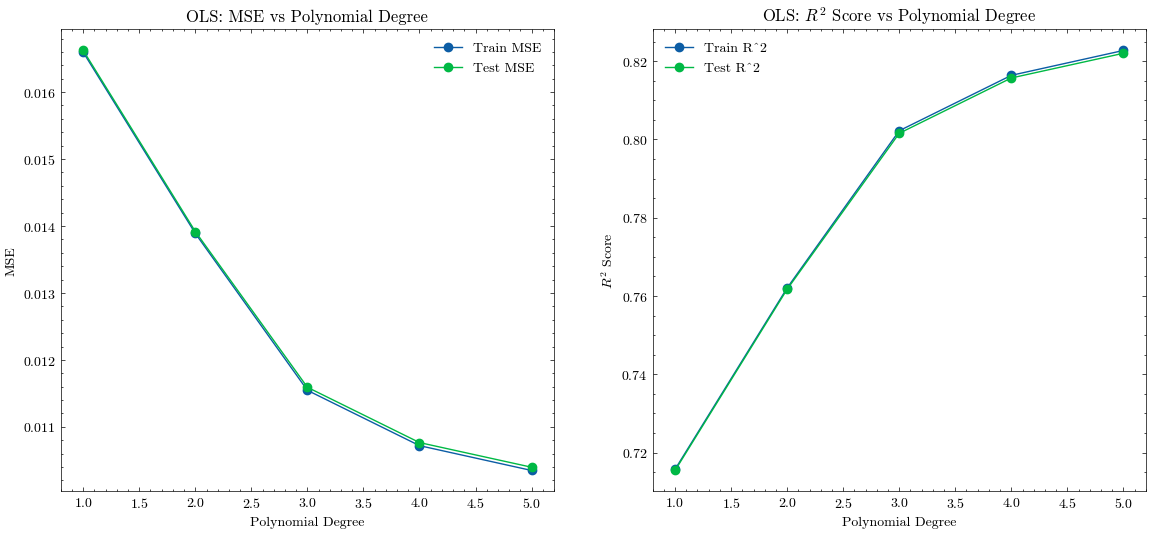

In [49]:
# Plot MSE and R^2 as a function of the polynomial degree
plt.figure(figsize=(14, 6))

# Plot MSE
plt.subplot(1, 2, 1)
plt.plot(degrees, mse_train_list, label='Train MSE', marker='o')
plt.plot(degrees, mse_test_list, label='Test MSE', marker='o')
plt.xlabel('Polynomial Degree')
plt.ylabel('MSE')
plt.title('OLS: MSE vs Polynomial Degree')
plt.legend()

# Plot R^2
plt.subplot(1, 2, 2)
plt.plot(degrees, r2_train_list, label='Train R^2', marker='o')
plt.plot(degrees, r2_test_list, label='Test R^2', marker='o')
plt.xlabel('Polynomial Degree')
plt.ylabel(r'$R^2$ Score')
plt.title(r'OLS: $R^2$ Score vs Polynomial Degree')
plt.legend()

plt.savefig('figures/ols_mse_r2.pdf', transparent=True, bbox_inches='tight')

plt.show()

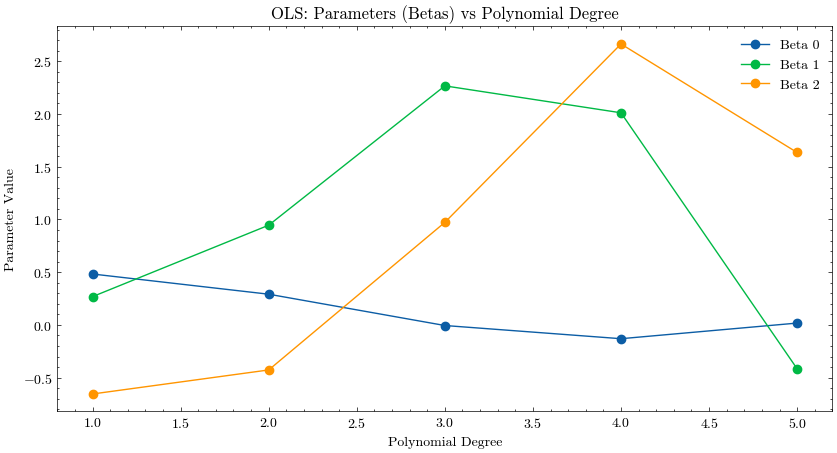

In [50]:
# Plot betas (parameters) for each polynomial degree
plt.figure(figsize=(10, 5))
num_betas = len(beta_coefficients[0])  # Get the number of beta coefficients for the first degree
for i in range(num_betas):  # Loop over the number of parameters
    plt.plot(degrees, [beta_coefficients[degree-1][i] for degree in degrees], marker='o', label=f'Beta {i}')

plt.title("OLS: Parameters (Betas) vs Polynomial Degree")
plt.xlabel('Polynomial Degree')
plt.ylabel('Parameter Value')
plt.legend()
plt.savefig('figures/terrain_ols_betas.pdf', transparent=True, bbox_inches='tight')
plt.show()

In [51]:
train_mse, test_mse = {}, {}
train_r2, test_r2 = {}, {}
degrees = np.arange(1, 6, 1)

def do_with_lambda(idx: int, lambda_: float):
    # Lists to store errors and R^2 values
    mse_train_list, mse_test_list = [], []
    r2_train_list, r2_test_list = [], []
    beta_coefficients = []

    for degree in degrees:
        poly = misc.design_matrix(degree=degree)
        X_train_poly = poly.fit_transform(X_train)
        X_test_poly = poly.transform(X_test)
        
        z_test_pred, z_train_pred, beta = misc.ridge(X_train_poly, z_train, X_test_poly, lambda_)
        
        # Calculate MSE and R^2
        mse_train = misc.mean_squared_error(z_train, z_train_pred)
        mse_test = misc.mean_squared_error(z_test, z_test_pred)
        r2_train = misc.r2_score(z_train, z_train_pred)
        r2_test = misc.r2_score(z_test, z_test_pred)
        
        # Append results to the lists
        mse_train_list.append(mse_train)
        mse_test_list.append(mse_test)
        r2_train_list.append(r2_train)
        r2_test_list.append(r2_test)
        beta_coefficients.append(beta)

    train_mse[idx] = mse_train_list
    test_mse[idx] = mse_test_list
    train_r2[idx] = r2_train_list
    test_r2[idx] = r2_test_list

lambdas = np.logspace(-6, 2, 8)

for idx, lambda_ in enumerate(lambdas):
    do_with_lambda(idx, lambda_)

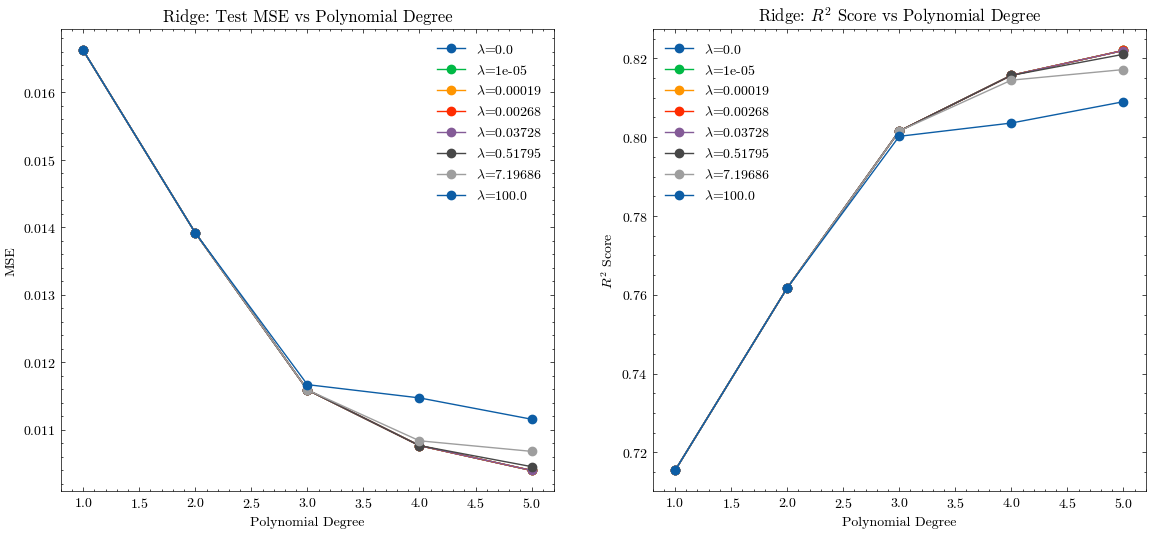

In [52]:
# Plot MSE and R^2 as a function of the polynomial degree
plt.figure(figsize=(14, 6))

# Plot MSE
plt.subplot(1, 2, 1)
for idx, lambda_ in enumerate(lambdas):
    plt.plot(degrees, test_mse[idx], label=f'$\lambda$={round(lambda_, 5)}', marker='o')
plt.xlabel('Polynomial Degree')
plt.ylabel('MSE')
plt.title('Ridge: Test MSE vs Polynomial Degree')
plt.legend()

# Plot R^2
plt.subplot(1, 2, 2)
for idx, lambda_ in enumerate(lambdas):
    plt.plot(degrees, test_r2[idx], label=f'$\lambda$={round(lambda_, 5)}', marker='o')
plt.xlabel('Polynomial Degree')
plt.ylabel(r'$R^2$ Score')
plt.title(r'Ridge: $R^2$ Score vs Polynomial Degree')
plt.legend()
plt.savefig('figures/terrain_ridge_mse_r2.pdf', transparent=True, bbox_inches='tight')
plt.show()

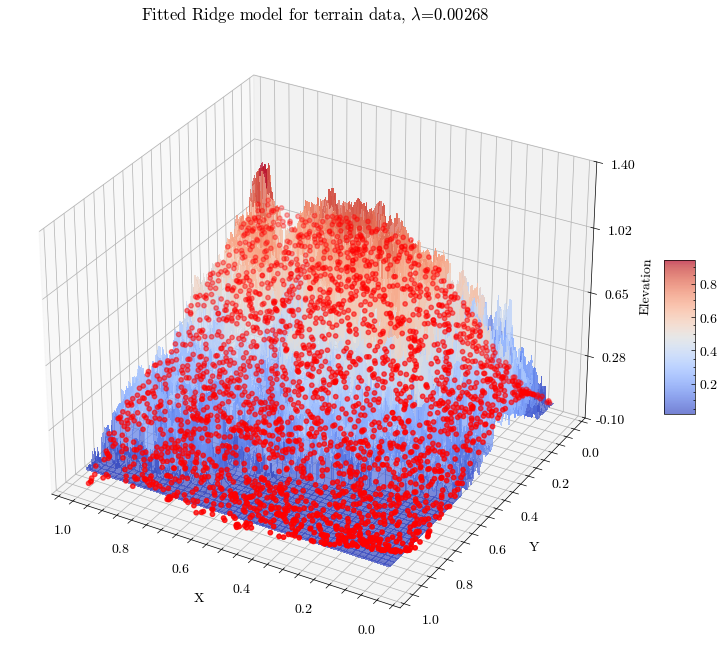

In [53]:
#Plot surface for the best lambda
#idx of lowest mse
idx = np.argmin([np.min(test_mse[i]) for i in range(len(lambdas))])
lambda_ = lambdas[idx]
degree = 5
poly = misc.design_matrix(degree=degree)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

z_test_pred, z_train_pred, beta = misc.ridge(X_train_poly, z_train, X_test_poly, lambda_)

every_nth = 500
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False, alpha=0.7)
ax.set_zlim(-0.10, 1.40)
ax.zaxis.set_major_locator(LinearLocator(5))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.scatter(X_test[::every_nth, 0], X_test[::every_nth, 1], z_test_pred[::every_nth], color='r', s=10)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Elevation")
ax.view_init(30, 30+90)
fig.colorbar(surf, shrink=0.2, aspect=5)
plt.title(f"Fitted Ridge model for terrain data, $\lambda$={round(lambda_, 5)}")
plt.savefig('figures/terrain_ridge_fit.pdf', transparent=True, bbox_inches='tight')
plt.show()


In [55]:
train_mse, test_mse = {}, {}
train_r2, test_r2 = {}, {}

# Polynomial Regression for degrees 1 to 5
degrees = np.arange(1, 6, 1)
poly_features = [misc.design_matrix(degree=degree) for degree in degrees]

def do_with_alpha(idx: int, alpha: float):
    print(f"Alpha: {alpha}")
    # Lists to store errors and R^2 values
    mse_train_list, mse_test_list = [], []
    r2_train_list, r2_test_list = [], []
    beta_coefficients = []

    for degree, poly in zip(degrees, poly_features):
        X_train_poly = poly.fit_transform(X_train)
        X_test_poly = poly.transform(X_test)
        
        z_test_pred, z_train_pred, beta = misc.lasso(X_train_poly, z_train, X_test_poly, alpha)
        
        # Calculate MSE and R^2
        mse_train = misc.mean_squared_error(z_train, z_train_pred)
        mse_test = misc.mean_squared_error(z_test, z_test_pred)
        r2_train = misc.r2_score(z_train, z_train_pred)
        r2_test = misc.r2_score(z_test, z_test_pred)
        
        # Append results to the lists
        mse_train_list.append(mse_train)
        mse_test_list.append(mse_test)
        r2_train_list.append(r2_train)
        r2_test_list.append(r2_test)
        beta_coefficients.append(beta)
        print(f"Degree: {degree}, Alpha: {alpha}, MSE Train: {mse_train}, MSE Test: {mse_test}, R2 Train: {r2_train}, R2 Test: {r2_test}")

    train_mse[idx] = mse_train_list
    test_mse[idx] = mse_test_list
    train_r2[idx] = r2_train_list
    test_r2[idx] = r2_test_list

alphas = np.logspace(-6, 0, 12)

for idx, alpha in enumerate(alphas):
    do_with_alpha(idx, alpha)


Alpha: 1e-06
Degree: 1, Alpha: 1e-06, MSE Train: 0.01659399558929318, MSE Test: 0.01662128619860224, R2 Train: 0.7157279291018894, R2 Test: 0.7154380936692435
Degree: 2, Alpha: 1e-06, MSE Train: 0.013889184367592768, MSE Test: 0.013917594501149745, R2 Train: 0.7620641043312801, R2 Test: 0.7617261880059152


c:\Users\mrant\Documents\university\Masters\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32334.975070957516, tolerance: 73.64091444930972
  model = cd_fast.enet_coordinate_descent_gram(


Degree: 3, Alpha: 1e-06, MSE Train: 0.012543713799548856, MSE Test: 0.012580211873106822, R2 Train: 0.7851133875887184, R2 Test: 0.7846226200619094


c:\Users\mrant\Documents\university\Masters\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30555.537918276335, tolerance: 73.64091444930972
  model = cd_fast.enet_coordinate_descent_gram(


Degree: 4, Alpha: 1e-06, MSE Train: 0.011860220202455609, MSE Test: 0.011899729921652046, R2 Train: 0.7968223300942028, R2 Test: 0.7962726956948005


c:\Users\mrant\Documents\university\Masters\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30213.6332758218, tolerance: 73.64091444930972
  model = cd_fast.enet_coordinate_descent_gram(


Degree: 5, Alpha: 1e-06, MSE Train: 0.011835468312552838, MSE Test: 0.011875244890326571, R2 Train: 0.7972463552160272, R2 Test: 0.7966918875134897
Alpha: 3.5111917342151275e-06
Degree: 1, Alpha: 3.5111917342151275e-06, MSE Train: 0.016593995713800797, MSE Test: 0.016621286118421424, R2 Train: 0.7157279269689469, R2 Test: 0.7154380950419654
Degree: 2, Alpha: 3.5111917342151275e-06, MSE Train: 0.013889202105807769, MSE Test: 0.013917594134788309, R2 Train: 0.7620638004575635, R2 Test: 0.7617261942781439


c:\Users\mrant\Documents\university\Masters\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31797.728090581935, tolerance: 73.64091444930972
  model = cd_fast.enet_coordinate_descent_gram(


Degree: 3, Alpha: 3.5111917342151275e-06, MSE Train: 0.012536550255141277, MSE Test: 0.012572990482530667, R2 Train: 0.785236106411485, R2 Test: 0.7847462526523212


c:\Users\mrant\Documents\university\Masters\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30027.91677448825, tolerance: 73.64091444930972
  model = cd_fast.enet_coordinate_descent_gram(


Degree: 4, Alpha: 3.5111917342151275e-06, MSE Train: 0.011865018629503305, MSE Test: 0.01190448024890418, R2 Train: 0.796740128144313, R2 Test: 0.7961913685241826


c:\Users\mrant\Documents\university\Masters\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29032.88967446744, tolerance: 73.64091444930972
  model = cd_fast.enet_coordinate_descent_gram(


Degree: 5, Alpha: 3.5111917342151275e-06, MSE Train: 0.011835891754219794, MSE Test: 0.011875609321756275, R2 Train: 0.797239101228347, R2 Test: 0.7966856483271161
Alpha: 1.2328467394420658e-05
Degree: 1, Alpha: 1.2328467394420658e-05, MSE Train: 0.016593997294090224, MSE Test: 0.016621287354220447, R2 Train: 0.7157278998969772, R2 Test: 0.7154380738846783
Degree: 2, Alpha: 1.2328467394420658e-05, MSE Train: 0.01388942843521136, MSE Test: 0.01391775567022249, R2 Train: 0.7620599232040162, R2 Test: 0.7617234287381887


c:\Users\mrant\Documents\university\Masters\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29872.57724890679, tolerance: 73.64091444930972
  model = cd_fast.enet_coordinate_descent_gram(


Degree: 3, Alpha: 1.2328467394420658e-05, MSE Train: 0.012512088098559996, MSE Test: 0.01254832968292961, R2 Train: 0.7856551681059742, R2 Test: 0.7851684536819088


c:\Users\mrant\Documents\university\Masters\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28116.874978624775, tolerance: 73.64091444930972
  model = cd_fast.enet_coordinate_descent_gram(


Degree: 4, Alpha: 1.2328467394420658e-05, MSE Train: 0.011885158024833463, MSE Test: 0.011924405437697372, R2 Train: 0.7963951197594228, R2 Test: 0.7958502427148293


c:\Users\mrant\Documents\university\Masters\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25609.974768869877, tolerance: 73.64091444930972
  model = cd_fast.enet_coordinate_descent_gram(


Degree: 5, Alpha: 1.2328467394420658e-05, MSE Train: 0.011840836975070752, MSE Test: 0.011880269285369286, R2 Train: 0.7971543845508725, R2 Test: 0.7966058682118285
Alpha: 4.328761281083062e-05
Degree: 1, Alpha: 4.328761281083062e-05, MSE Train: 0.01659403927404102, MSE Test: 0.01662131487968457, R2 Train: 0.715727180737599, R2 Test: 0.7154376026396465
Degree: 2, Alpha: 4.328761281083062e-05, MSE Train: 0.013891998001327628, MSE Test: 0.013920106059810389, R2 Train: 0.7620159039153975, R2 Test: 0.7616831892925909


c:\Users\mrant\Documents\university\Masters\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19576.10160487856, tolerance: 73.64091444930972
  model = cd_fast.enet_coordinate_descent_gram(


Degree: 3, Alpha: 4.328761281083062e-05, MSE Train: 0.012485323475097322, MSE Test: 0.012521434182866224, R2 Train: 0.786113673406738, R2 Test: 0.7856289135210757


c:\Users\mrant\Documents\university\Masters\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21257.77929071601, tolerance: 73.64091444930972
  model = cd_fast.enet_coordinate_descent_gram(


Degree: 4, Alpha: 4.328761281083062e-05, MSE Train: 0.011947736018536539, MSE Test: 0.011985758537545658, R2 Train: 0.7953230948955556, R2 Test: 0.7947998573930486


c:\Users\mrant\Documents\university\Masters\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14729.440756659977, tolerance: 73.64091444930972
  model = cd_fast.enet_coordinate_descent_gram(


Degree: 5, Alpha: 4.328761281083062e-05, MSE Train: 0.011911173365134968, MSE Test: 0.01194893570750405, R2 Train: 0.7959494504435046, R2 Test: 0.7954302763984089
Alpha: 0.0001519911082952933
Degree: 1, Alpha: 0.0001519911082952933, MSE Train: 0.01659465722695386, MSE Test: 0.016621882496522064, R2 Train: 0.7157165945738686, R2 Test: 0.7154278848520208
Degree: 2, Alpha: 0.0001519911082952933, MSE Train: 0.013907067650042302, MSE Test: 0.01393449763167553, R2 Train: 0.7617577454613486, R2 Test: 0.7614368008316675


c:\Users\mrant\Documents\university\Masters\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3329.2197840049485, tolerance: 73.64091444930972
  model = cd_fast.enet_coordinate_descent_gram(


Degree: 3, Alpha: 0.0001519911082952933, MSE Train: 0.012902913222795553, MSE Test: 0.012935185313198955, R2 Train: 0.7789599350725788, R2 Test: 0.7785453575924203


c:\Users\mrant\Documents\university\Masters\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4445.205698894388, tolerance: 73.64091444930972
  model = cd_fast.enet_coordinate_descent_gram(


Degree: 4, Alpha: 0.0001519911082952933, MSE Train: 0.012173031608172931, MSE Test: 0.012207730035683968, R2 Train: 0.7914635516357351, R2 Test: 0.7909996320731426


c:\Users\mrant\Documents\university\Masters\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 978.3051805326832, tolerance: 73.64091444930972
  model = cd_fast.enet_coordinate_descent_gram(


Degree: 5, Alpha: 0.0001519911082952933, MSE Train: 0.012090596100061806, MSE Test: 0.012125506589510933, R2 Train: 0.7928757559767685, R2 Test: 0.7924073246132092
Alpha: 0.0005336699231206307
Degree: 1, Alpha: 0.0005336699231206307, MSE Train: 0.01660262817859616, MSE Test: 0.016629681842110857, R2 Train: 0.7155800440415876, R2 Test: 0.7152943574810123
Degree: 2, Alpha: 0.0005336699231206307, MSE Train: 0.014094430770309599, MSE Test: 0.014119670690989607, R2 Train: 0.7585480240942607, R2 Test: 0.7582665769314292
Degree: 3, Alpha: 0.0005336699231206307, MSE Train: 0.014116917298045945, MSE Test: 0.014143079432346946, R2 Train: 0.7581628069370956, R2 Test: 0.7578658115522728
Degree: 4, Alpha: 0.0005336699231206307, MSE Train: 0.014117558858021817, MSE Test: 0.014143758504409376, R2 Train: 0.7581518163602954, R2 Test: 0.7578541856144054
Degree: 5, Alpha: 0.0005336699231206307, MSE Train: 0.013561379610898355, MSE Test: 0.013588944921853967, R2 Train: 0.7676797341857257, R2 Test: 0.76735

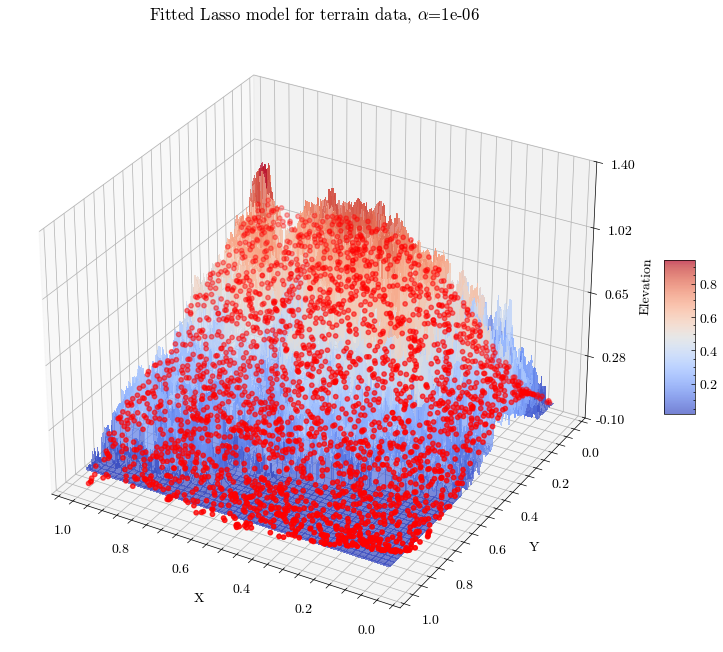

In [56]:
#Plot surface for the best alpha
#idx of lowest mse
idx = np.argmin([np.min(test_mse[i]) for i in range(len(alphas))])
alpha = alphas[idx]
degree = 5
poly = misc.design_matrix(degree=degree)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

z_test_pred, z_train_pred, beta = misc.ridge(X_train_poly, z_train, X_test_poly, alpha)

every_nth = 500
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False, alpha=0.7)
ax.set_zlim(-0.10, 1.40)
ax.zaxis.set_major_locator(LinearLocator(5))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.scatter(X_test[::every_nth, 0], X_test[::every_nth, 1], z_test_pred[::every_nth], color='r', s=10)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Elevation")
ax.view_init(30, 30+90)
fig.colorbar(surf, shrink=0.2, aspect=5)
plt.title(r"Fitted Lasso model for terrain data, $\alpha$={}".format(alpha, 5))
plt.savefig('figures/terrain_lasso_fit.pdf', transparent=True, bbox_inches='tight')
plt.show()


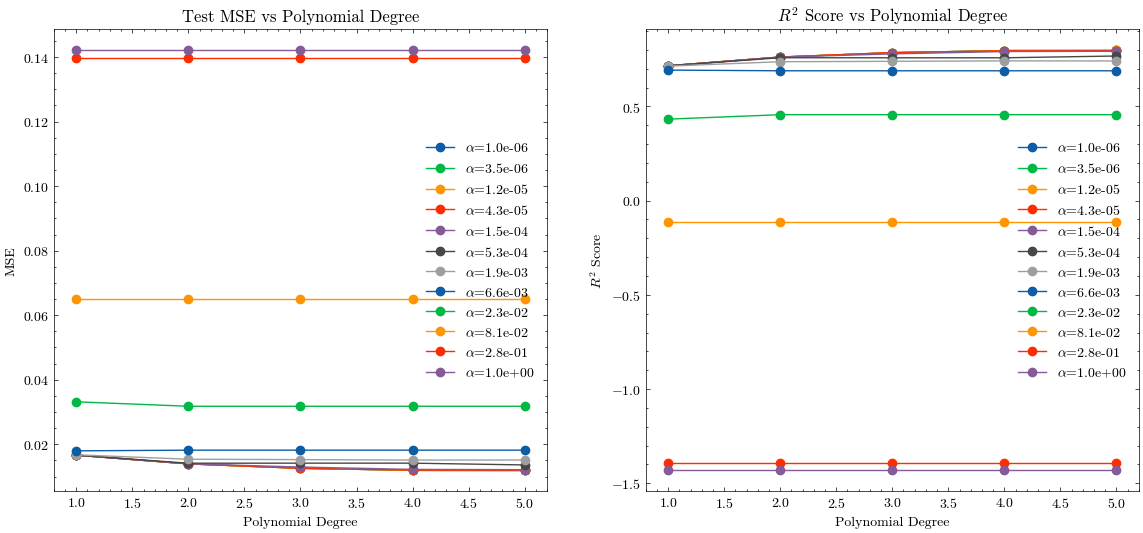

In [57]:
degrees = np.arange(1, 6, 1)

# Plot MSE and R^2 as a function of the polynomial degree
plt.figure(figsize=(14, 6))

# Plot MSE
plt.subplot(1, 2, 1)
for idx, alpha in enumerate(alphas):
    plt.plot(degrees, test_mse[idx], label=r'$\alpha$={:.1e}'.format(alpha), marker='o')
plt.xlabel('Polynomial Degree')
plt.ylabel('MSE')
plt.title('Test MSE vs Polynomial Degree')
plt.legend()

# Plot R^2 as a function of the polynomial degree

# Plot R^2
plt.subplot(1, 2, 2)
for idx, alpha in enumerate(alphas):
    plt.plot(degrees, test_r2[idx], label=r'$\alpha$={:.1e}'.format(alpha), marker='o')
plt.xlabel('Polynomial Degree')
plt.ylabel(r'$R^2$ Score')
plt.title(r'$R^2$ Score vs Polynomial Degree')
plt.legend()
plt.savefig('figures/terrain_lasso_mse_r2.pdf', transparent=True, bbox_inches='tight')
plt.show()

In [105]:
from sklearn.pipeline import make_pipeline
from sklearn.utils import resample
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import miscellaneous as misc

n_boostraps = 20  # Number of bootstrap samples
degrees = np.arange(1, 6, 1)
maxdegree = max(degrees)

# Prepare variables for bias-variance analysis
error = np.zeros(maxdegree)
bias = np.zeros(maxdegree)
variance = np.zeros(maxdegree)
polydegree = np.zeros(maxdegree)

# Bias-Variance tradeoff for polynomial degrees
for degree in degrees:
    model = make_pipeline(PolynomialFeatures(degree=degree), LinearRegression(fit_intercept=False))
    z_pred = np.empty((X_test.shape[0], n_boostraps))  # Ensure z_pred matches the shape of z_test
    
    for i in range(n_boostraps):
        x_, y_ = resample(X_train, z_train)  # Resample the training data
        z_pred[:, i] = model.fit(x_, y_).predict(X_test).ravel()  # Predict on the same test data size

    # Store results for error, bias^2, and variance
    polydegree[degree] = degree
    error[degree] = np.mean( np.mean((z_test.reshape(-1, 1) - z_pred)**2, axis=1, keepdims=True) )
    bias[degree] = np.mean( (z_test.reshape(-1, 1) - np.mean(z_pred, axis=1, keepdims=True))**2 )
    variance[degree] = np.mean( np.var(z_pred, axis=1, keepdims=True) )
    
    # Output results for each polynomial degree
    print(f'Polynomial degree: {degree}')
    print(f'Error: {error[degree]}')
    print(f'Bias^2: {bias[degree]}')
    print(f'Variance: {variance[degree]}')
    print(f'{error[degree]} >= {bias[degree]} + {variance[degree]} = {bias[degree] + variance[degree]}')

Polynomial degree: 1
Error: 0.01076253791223883
Bias^2: 0.010762058289107004
Variance: 4.796231318292234e-07
0.01076253791223883 >= 0.010762058289107004 + 4.796231318292234e-07 = 0.010762537912238832


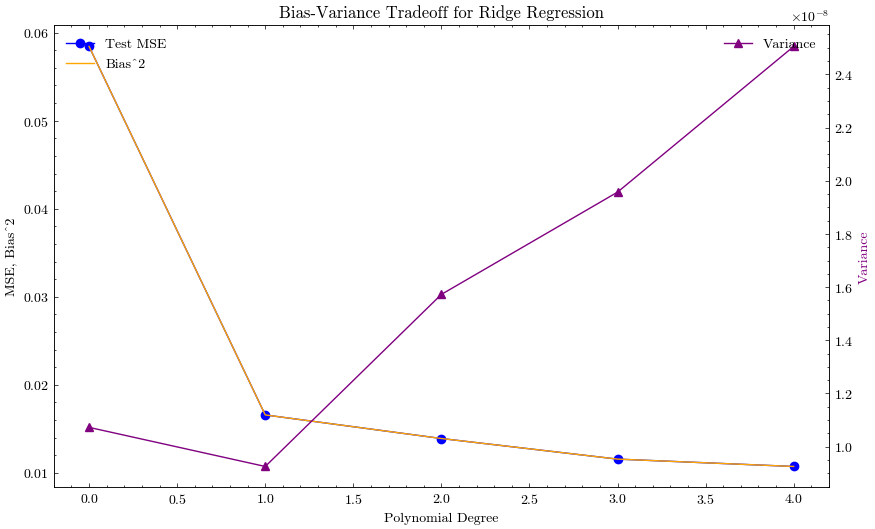

In [58]:
# Create the plot with two y-axes
fig, ax1 = plt.subplots(figsize=(10, 6))

# First y-axis for MSE and Bias
ax1.plot(degrees, error, 'o-', label='Test MSE', color='blue')
ax1.plot(degrees, bias, label='Bias^2', color='orange')
ax1.set_xlabel('Polynomial Degree')
ax1.set_ylabel('MSE, Bias^2')
ax1.tick_params(axis='y', labelcolor='black')

# Second y-axis for Variance
ax2 = ax1.twinx()  # Create a secondary y-axis
ax2.plot(degrees, variance, '^-', label='Variance', color='purple')
ax2.set_ylabel('Variance', color='purple')  # Label for second y-axis
# ax2.set_ylim([min(variance) - 1e-5, max(variance) + 1e-5])
ax2.ticklabel_format(style='sci', axis='y', scilimits=(0,0))


# Create legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.title('Bias-Variance Tradeoff for Ridge Regression')
plt.savefig('figures/terrain_bias_variance.pdf', transparent=True, bbox_inches='tight')
plt.show()

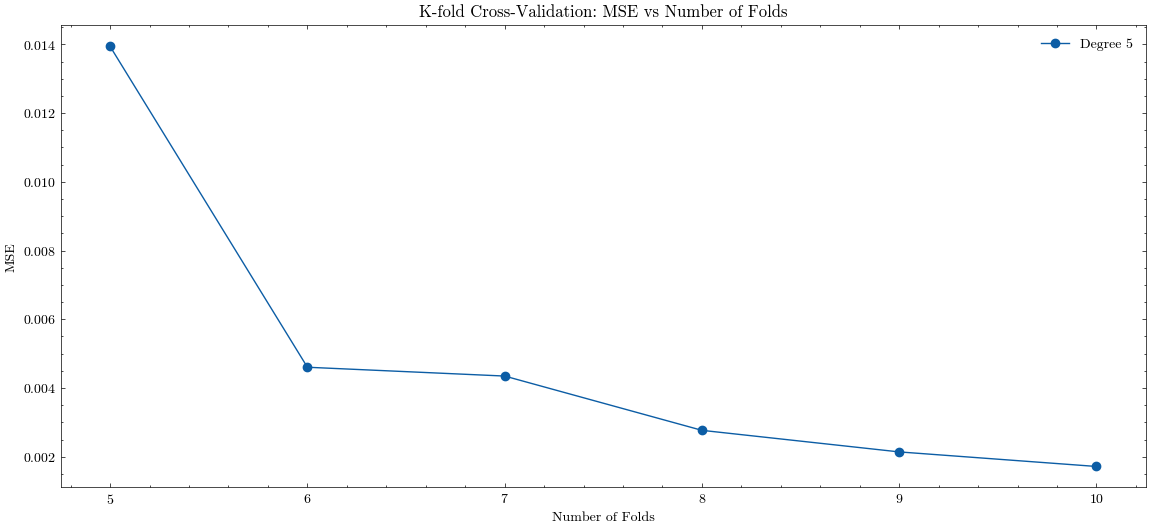

In [77]:
# K-fold cross-validation for OLS with different numbers of folds

from sklearn.model_selection import KFold

# Prepare variables for K-fold cross-validation
degree = 5  # Keep the degree constant
folds_range = range(5, 11)
mse_kfold = np.zeros(len(folds_range))
r2_kfold = np.zeros(len(folds_range))

# K-fold cross-validation
poly = misc.design_matrix(degree=degree)
for j, k_folds in enumerate(folds_range):
    kfold = KFold(n_splits=k_folds)
    scores = np.zeros(k_folds)
    for i, (train_inds, test_inds) in enumerate(kfold.split(X_design)):
        x_train = X_design[train_inds]
        z_train = z_data[train_inds]

        x_test = X_design[test_inds]
        z_test = z_data[test_inds]

        X_train = poly.fit_transform(x_train)
        X_test = poly.fit_transform(x_test)
        z_test_pred, z_train_pred, beta = misc.ols(X_train, z_train, X_test)

        scores[i] = np.sum((z_test_pred - z_test)**2) / np.size(z_train_pred)

    mse_kfold[j] = np.mean(scores)


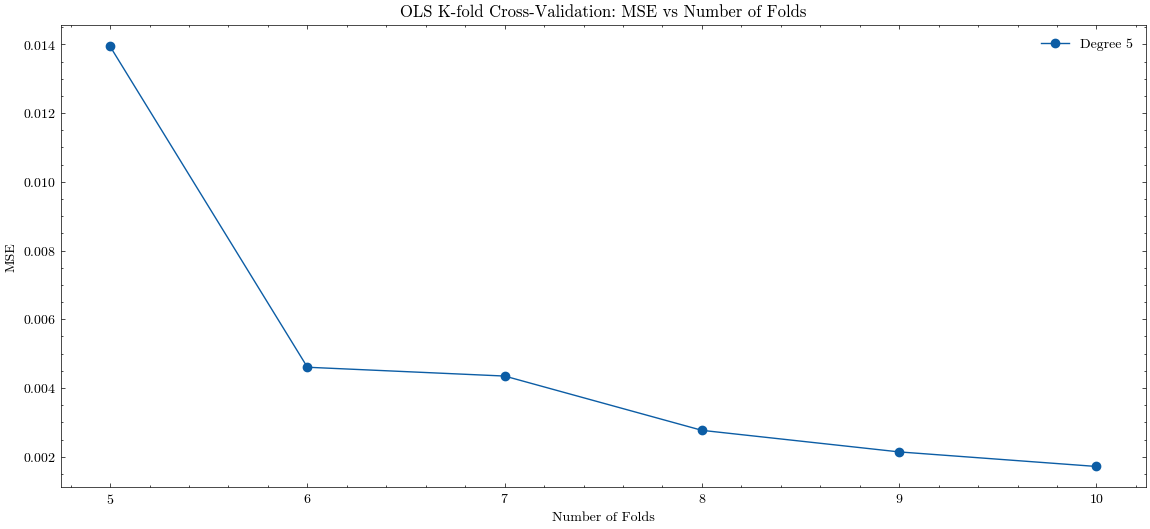

In [81]:
# Plot the results
plt.figure(figsize=(14, 6))
plt.plot(folds_range, mse_kfold, label=f'Degree {degree}', marker='o')

plt.xlabel('Number of Folds')
plt.ylabel('MSE')
plt.title('OLS K-fold Cross-Validation: MSE vs Number of Folds')
plt.legend()
plt.savefig('figures/terrain_kfold_ols.pdf', transparent=True, bbox_inches='tight')
plt.show()

In [94]:
# K-fold cross-validation for Ridge with different lambdas

from sklearn.model_selection import KFold

# Prepare variables for K-fold cross-validation
degree = 5  # Keep the degree constant
folds_range = range(5, 11)
mse_kfold = np.zeros((len(folds_range), len(lambdas)))
r2_kfold = np.zeros((len(folds_range), len(lambdas)))

# K-fold cross-validation
poly = misc.design_matrix(degree=degree)
for j, k_folds in enumerate(folds_range):
    kfold = KFold(n_splits=k_folds)
    for k, lambda_ in enumerate(lambdas):
        scores = np.zeros(k_folds)
        for i, (train_inds, test_inds) in enumerate(kfold.split(X_design)):
            x_train = X_design[train_inds]
            z_train = z_data[train_inds]

            x_test = X_design[test_inds]
            z_test = z_data[test_inds]

            X_train = poly.fit_transform(x_train)
            X_test = poly.fit_transform(x_test)
            z_test_pred, z_train_pred, beta = misc.ridge(X_train, z_train, X_test, lambda_)

            scores[i] = np.sum((z_test_pred - z_test)**2) / np.size(z_train_pred)

        mse_kfold[j, k] = np.mean(scores)
    print(f'Completed {j+1}/{len(folds_range)} folds')


Completed 1/6 folds
Completed 2/6 folds
Completed 3/6 folds
Completed 4/6 folds
Completed 5/6 folds
Completed 6/6 folds


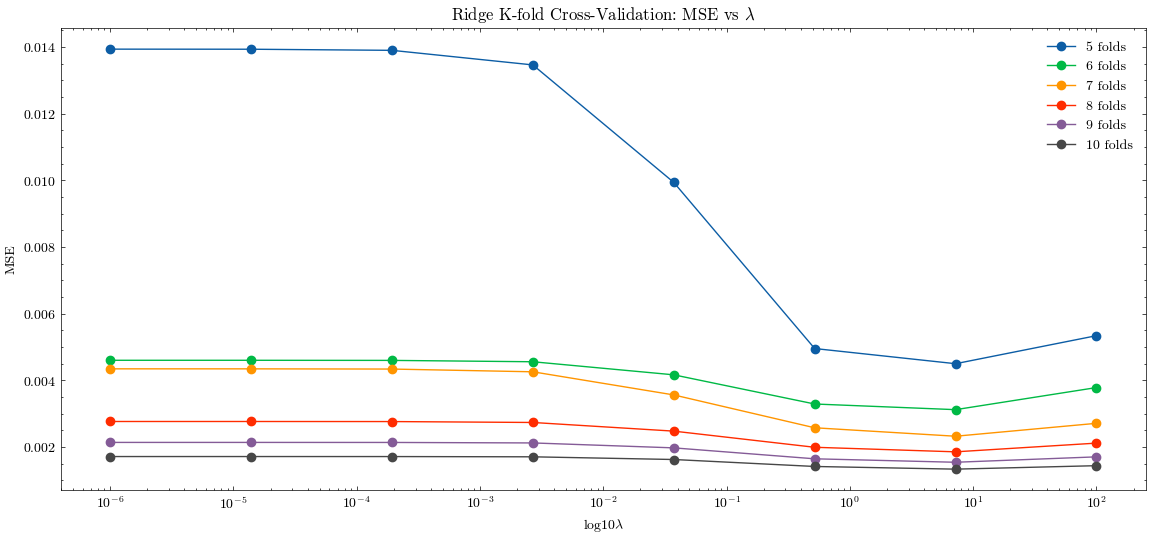

In [95]:
# Plot the results
plt.figure(figsize=(14, 6))
for i in range(len(folds_range)):
    plt.plot(lambdas, mse_kfold[i], label=f'{folds_range[i]} folds', marker='o')

plt.xlabel('log10$\lambda$')
plt.xscale('log')
plt.ylabel('MSE')
plt.title('Ridge K-fold Cross-Validation: MSE vs $\lambda$')
plt.legend()
plt.savefig('figures/terrain_kfold_ridge.pdf', transparent=True, bbox_inches='tight')
plt.show()

# We can see that the best lambda is around 10e0, which is the same as the one we found earlier

In [96]:
# K-fold cross-validation for Lasso with different lambdas

from sklearn.model_selection import KFold

# Prepare variables for K-fold cross-validation
degree = 5  # Keep the degree constant
folds_range = range(5, 11)
mse_kfold = np.zeros((len(folds_range), len(alphas)))
r2_kfold = np.zeros((len(folds_range), len(alphas)))

# K-fold cross-validation
poly = misc.design_matrix(degree=degree)
for j, k_folds in enumerate(folds_range):
    kfold = KFold(n_splits=k_folds)
    for k, alpha in enumerate(alphas):
        scores = np.zeros(k_folds)
        for i, (train_inds, test_inds) in enumerate(kfold.split(X_design)):
            x_train = X_design[train_inds]
            z_train = z_data[train_inds]

            x_test = X_design[test_inds]
            z_test = z_data[test_inds]

            X_train = poly.fit_transform(x_train)
            X_test = poly.fit_transform(x_test)
            z_test_pred, z_train_pred, beta = misc.lasso(X_train, z_train, X_test, alpha)

            scores[i] = np.sum((z_test_pred - z_test)**2) / np.size(z_train_pred)

        mse_kfold[j, k] = np.mean(scores)
    print(f'Completed {j+1}/{len(folds_range)} folds')


c:\Users\mrant\Documents\university\Masters\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21454.97303375885, tolerance: 47.35088932922551
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\mrant\Documents\university\Masters\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25516.939271072235, tolerance: 61.61922689570728
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\mrant\Documents\university\Masters\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31244.979630409016, tolerance: 79.75857345098548
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\mrant\Do

Completed 1/6 folds


c:\Users\mrant\Documents\university\Masters\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23922.239974665685, tolerance: 54.230094444846095
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\mrant\Documents\university\Masters\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27586.277552442545, tolerance: 62.62510339139265
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\mrant\Documents\university\Masters\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29704.188438778197, tolerance: 76.44457966534175
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\mrant\

Completed 2/6 folds


c:\Users\mrant\Documents\university\Masters\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27362.810695478398, tolerance: 58.67882214673206
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\mrant\Documents\university\Masters\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28123.861873608734, tolerance: 64.76373702615936
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\mrant\Documents\university\Masters\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29363.1744263841, tolerance: 74.74225373287474
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\mrant\Doc

Completed 3/6 folds


c:\Users\mrant\Documents\university\Masters\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28541.17149159854, tolerance: 62.29151032068499
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\mrant\Documents\university\Masters\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29514.217834567735, tolerance: 67.35273702342256
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\mrant\Documents\university\Masters\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29914.57867750163, tolerance: 74.1996361600396
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\mrant\Docu

Completed 4/6 folds


c:\Users\mrant\Documents\university\Masters\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29637.43656994062, tolerance: 65.03775569379216
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\mrant\Documents\university\Masters\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30281.629777640133, tolerance: 69.88056824218461
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\mrant\Documents\university\Masters\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31287.90480735332, tolerance: 74.0012283196391
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\mrant\Docu

Completed 5/6 folds


c:\Users\mrant\Documents\university\Masters\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30675.21739686273, tolerance: 67.42553683839735
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\mrant\Documents\university\Masters\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30727.876698326505, tolerance: 71.98970691020496
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\mrant\Documents\university\Masters\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32246.404562262196, tolerance: 73.93644750410063
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\mrant\Do

Completed 6/6 folds


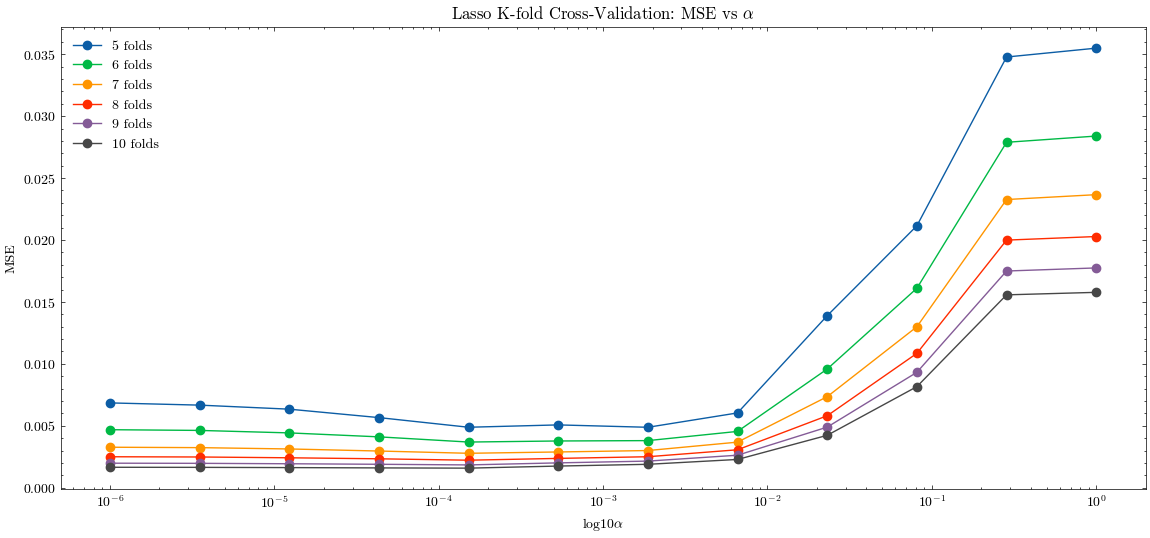

In [102]:
# Plot the results
plt.figure(figsize=(14, 6))
for i in range(len(folds_range)):
    plt.plot(alphas, mse_kfold[i], label=f'{folds_range[i]} folds', marker='o')

plt.xlabel(r'log10$\alpha$')
plt.xscale('log')
plt.ylabel('MSE')
plt.title(r'Lasso K-fold Cross-Validation: MSE vs $\alpha$')
plt.legend()
plt.savefig('figures/terrain_kfold_lasso.pdf', transparent=True, bbox_inches='tight')
plt.show()

# We can see that the best alpha is around 10e-4, which is the same as the one we found earlier